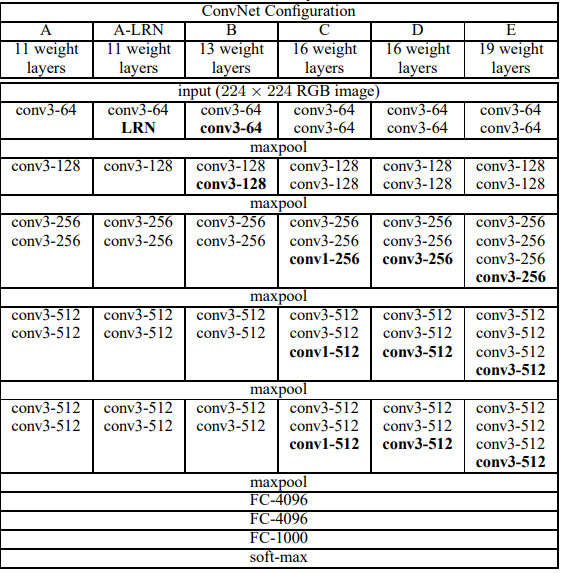

In [1]:
import torch    
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm 

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VGG16(nn.Module):
    def __init__(self, out_nc):
        super().__init__()
        
        self.act = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        # self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, out_nc)

    def forward(self, x):
        out = self.conv1_1(x)
        out = self.act(out)
        out = self.conv1_2(out)
        out = self.act(out)

        out = self.maxpool(out)

        out = self.conv2_1(out)
        out = self.act(out)
        out = self.conv2_2(out)
        out = self.act(out)

        out = self.maxpool(out)
        
        out = self.conv3_1(out)
        out = self.act(out)
        out = self.conv3_2(out)
        out = self.act(out)
        out = self.conv3_3(out)
        out = self.act(out)

        out = self.maxpool(out)

        out = self.conv4_1(out)
        out = self.act(out)
        out = self.conv4_2(out)
        out = self.act(out)
        out = self.conv4_3(out)
        out = self.act(out)

        out = self.maxpool(out)

        # out = self.conv5_1(out)
        # out = self.act(out)
        # out = self.conv5_2(out)
        # out = self.act(out)
        # out = self.conv5_3(out)
        # out = self.act(out)

        out = self.maxpool(out)

        out = self.flatten(out)

        out = self.fc1(out)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)

        return out

In [3]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()

        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2

        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))

    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)

    def __getitem__(self, idx):
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Изображение по пути {img_path} не может быть загружено.")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0

        img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)

        img = img.transpose((2, 0, 1))

        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor([class_id])

        return {'img' : t_img, 'label' :  t_class_id}

In [4]:
train_ds_catsdogs = Dataset2class('C:/Users/Administrator/Desktop/AAT/ResNet/dataset/training_set/cats',
                             'C:/Users/Administrator/Desktop/AAT/ResNet/dataset/training_set/dogs')
test_ds_catsdogs = Dataset2class('C:/Users/Administrator/Desktop/AAT/ResNet/dataset/test_set/cats',
                             'C:/Users/Administrator/Desktop/AAT/ResNet/dataset/test_set/dogs')


In [5]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True, batch_size=batch_size,
    num_workers=0, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    test_ds_catsdogs, shuffle=True, batch_size=batch_size,
    num_workers=0, drop_last=False)

In [6]:
model = VGG16(1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [7]:
torch.cuda.empty_cache()

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = model.to(device)

cuda


In [9]:
def accuracy(pred, label):
    answer = (F.sigmoid(pred.detach().cpu()).numpy() > 0.5) == (label.cpu().numpy() > 0.5)
    # print(answer)
    # print(answer.sum())
    return answer.mean()


In [10]:
for sample in train_loader:
    print(sample['label'].float())
    break

tensor([[1.],
        [1.],
        [1.],
        [0.]])


In [11]:
epochs = 7
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'].to(device), sample['label'].to(device).float()
        optimizer.zero_grad()
        
        #label = F.one_hot(label, 2).float()
        pred = model(img)
        loss = loss_fn(pred, label)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

        acc_current = accuracy(pred, label)
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.4f}\taccuracy: {acc_current:.3f}')
    print(loss_val/len(train_loader))
    print(acc_val/len(train_loader))

loss: 0.6901	accuracy: 1.000: 100%|██████████| 2000/2000 [05:52<00:00,  5.67it/s]


0.695866914600134
0.4935


loss: 0.6936	accuracy: 0.250: 100%|██████████| 2000/2000 [11:33<00:00,  2.89it/s]


0.6932730270326137
0.495


loss: 0.6932	accuracy: 0.500: 100%|██████████| 2000/2000 [13:18<00:00,  2.51it/s]


0.6932359266877174
0.50175


loss: 0.6932	accuracy: 0.500: 100%|██████████| 2000/2000 [12:59<00:00,  2.56it/s]


0.6932249220311641
0.499


loss: 0.6922	accuracy: 0.750: 100%|██████████| 2000/2000 [12:26<00:00,  2.68it/s]


0.6932388759553433
0.49675


loss: 0.6932	accuracy: 0.500:   1%|          | 13/2000 [00:04<12:36,  2.63it/s]


KeyboardInterrupt: 